# PyTorch 2D convolutions
#### Christian Igel, 2021

## Mount driver and establish workspace
First part is only of interest if you are using Google Colab.

In [1]:
# import os
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)

In [2]:
## go to your folder
#os.chdir('$Your Space')

In [3]:
import torch
import torch.nn as nn

## One input channel, one output, no padding
Let's define a `W`$\times$`W` filter. For the following examples, we do not need a bias parameter.

In [4]:
# Convolution filter is of size W
W = 3
# 1 input (image) channel, 1 output channel, WxW convolution kernel
conv = nn.Conv2d(1, 1, W, bias=False)
print("We just defined:", conv)

We just defined: Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)


Let's look at the kernel dimensions:

In [5]:
# 1 output channel, 1 input channel, 1st dimension = W, 2nd dimension = W
print(conv.weight.shape)

torch.Size([1, 1, 3, 3])


The filter parameters are initialized randomly:

In [6]:
print(conv.weight)

Parameter containing:
tensor([[[[ 0.0107,  0.3102,  0.1789],
          [-0.2836,  0.1739, -0.2560],
          [ 0.0037,  0.2265, -0.0919]]]], requires_grad=True)


We can set the parameters as follows:

In [7]:
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print(conv.weight)

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)


Let's define an input (image) `x`. The input is of the same shape as the filter:

In [8]:
x = torch.arange(float(W*W))
x = torch.reshape(x, (1, 1, W, W))
print('Input:\n', x)
print('Sum of all input elements:', torch.sum(x).item())

Input:
 tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Sum of all input elements: 36.0


Because there is no padding and input and filter have the same size, there is only one valid position for the filter. Accordingly, the result is a tensor with a single value:

In [9]:
c = conv(x)
print('Tensor:', c, 'scalar:', c.item())

Tensor: tensor([[[[36.]]]], grad_fn=<ThnnConv2DBackward>) scalar: 36.0


The scalar should be equal to the sum of all input elements (ensure that you understand why).

## One input channel, one output,  padding
Now we add zero-padding such that the input dimensionality is preseved:


In [10]:
conv = nn.Conv2d(1, 1, W, padding=W//2, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
c = conv(x)
print(c)

tensor([[[[ 8., 15., 12.],
          [21., 36., 27.],
          [20., 33., 24.]]]], grad_fn=<ThnnConv2DBackward>)


## Several input channels, one output, no padding
Typically, the input to a convolutional layer consists of several feature maps or channels. For example, consider a 2D input with three channels (e.g., an RGB colour image):

In [11]:
x = torch.arange(float(3*W*W))
x = torch.reshape(x, (1, 3, W, W))
print('Input:', x)
print('Sum of all inputs:', torch.sum(x).item())

Input: tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]],

         [[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]]]])
Sum of all inputs: 351.0


Let's define a convolutional layer that takes three channels as input and produces a single output feature map:

In [12]:
# 3 input (image) channels, 1 output channel, WxW convolution kernel
conv = nn.Conv2d(3, 1, W, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print('Weight parameters of convolutional layer:', conv.weight)

Weight parameters of convolutional layer: Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)


Note that there is one filter for each input channel.
The convolutional layer first convolves each input channel with the corresponding filter.
This results in three feature maps, whih are added to give the final result:

In [13]:
c = conv(x)
print('number of filter parameters:', conv.weight.numel(), '\nresult of filtering the input:', c)

number of filter parameters: 27 
result of filtering the input: tensor([[[[351.]]]], grad_fn=<ThnnConv2DBackward>)


It is important that the number of parameters and the dimesionality of the result is clear to you.

Now let's apply 1$\times$1 convolutions to our three input channels. Again, we set all filter weights to 1.

In [14]:
# 3 input (image) channels, 1 output channel, 1x1 convolution kernel
conv = nn.Conv2d(3, 1, 1, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print(conv.weight)

Parameter containing:
tensor([[[[1.]],

         [[1.]],

         [[1.]]]], requires_grad=True)


This convolutional layer adds the three input feature maps/channels:

In [15]:
c = conv(x)
print(c)

tensor([[[[27., 30., 33.],
          [36., 39., 42.],
          [45., 48., 51.]]]], grad_fn=<ThnnConv2DBackward>)


Thus, 1$\times$1 convolutions can be used to compute weighted sums of input feature maps/channels (in our previous example, all weights were set to 1). 

## Several output maps
Typically, convolutional layer produce several feature maps or channels. For example, consider 
extending the previous 1$\times$1 example to two output maps:

In [16]:
# 3 input (image) channels, 2 output channel, 1x1 convolution kernel
conv = nn.Conv2d(3, 2, 1, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print(conv.weight)

Parameter containing:
tensor([[[[1.]],

         [[1.]],

         [[1.]]],


        [[[1.]],

         [[1.]],

         [[1.]]]], requires_grad=True)


This layer maps 3 input feature maps to 2 output feature maps, which are identical in our example, because we initialized all filters so that they are identical: 

In [17]:
c = conv(x)
print(c)

tensor([[[[27., 30., 33.],
          [36., 39., 42.],
          [45., 48., 51.]],

         [[27., 30., 33.],
          [36., 39., 42.],
          [45., 48., 51.]]]], grad_fn=<ThnnConv2DBackward>)


The first convolutional layer in a network has typically more output feature maps than input channels. Let's assume 3 input channels, 4 output channels of the same dimensionality (i.e., we use padding), and a filter size of 3. For each output channel, we have 3 filter with 9 parameters/weights each. Thus, we have 108 parameters in total:

In [18]:
conv = nn.Conv2d(3, 4, W, padding=W//2, bias=False)
print(conv.weight)
print("Number of parameters:", conv.weight.shape.numel())

Parameter containing:
tensor([[[[ 0.1752,  0.1117,  0.1383],
          [-0.1383,  0.0271, -0.1144],
          [ 0.0998,  0.1569, -0.1383]],

         [[ 0.1219,  0.0400, -0.1895],
          [-0.0094,  0.0915, -0.0142],
          [-0.1038, -0.0834, -0.0262]],

         [[-0.1120,  0.1605,  0.0223],
          [-0.0506, -0.0026, -0.1359],
          [ 0.0292, -0.1733, -0.1058]]],


        [[[-0.0033,  0.0363,  0.1170],
          [ 0.0910,  0.0520, -0.1350],
          [-0.0843,  0.1325, -0.0583]],

         [[-0.0244, -0.1826,  0.1331],
          [-0.0110, -0.0845, -0.0105],
          [ 0.0119, -0.1643,  0.1113]],

         [[-0.0913, -0.1892, -0.0941],
          [-0.0062,  0.0215, -0.0250],
          [ 0.0444,  0.0776,  0.1684]]],


        [[[ 0.0753, -0.1638, -0.0211],
          [ 0.0695, -0.1574,  0.0074],
          [-0.0059, -0.1845,  0.1265]],

         [[ 0.1490,  0.0778, -0.1066],
          [ 0.0633, -0.0634,  0.1112],
          [ 0.0337,  0.1484,  0.0125]],

         [[ 0.1150,  0

And here are the resulting feature maps when applied to our input:

In [19]:
c = conv(x)
print(c)

tensor([[[[ -9.4541, -11.3007,  -4.8625],
          [ -9.0946, -12.0964,  -2.1934],
          [ -0.1876,  -2.6014,   3.9532]],

         [[  3.8852,   4.5839,   0.4094],
          [ -1.2466,  -2.4535,  -7.0524],
          [ -8.1044, -10.4528,  -9.2219]],

         [[  0.7627,  -3.5707,  -5.1864],
          [  5.3212,   4.1615,   0.5484],
          [  7.5263,  11.4603,   9.3233]],

         [[ -0.8080,  -6.3209,  -5.0496],
          [ -2.9992,  -6.8859,  -2.7205],
          [ -2.8570,  -1.6235,  -1.1006]]]], grad_fn=<ThnnConv2DBackward>)


# Image processing examples
Now we consider a more complex example that involves some basic image transformations. First, we need to import NumPy and some image utilities.

In [20]:
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Let's load an image and convert it to grayscale so that we just deal with a single channel: 

In [21]:
image = Image.open('diku.jpg')  # Load image
image = torchvision.transforms.functional.to_grayscale(image)  # Transform to grayscale, because we only wnat one channel

Let's plot the image:

PIL image shape: (1536, 2048) min: 0 max: 255


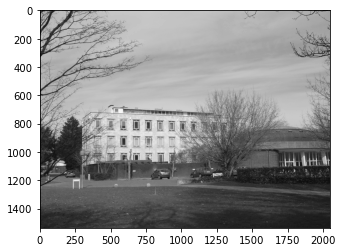

In [22]:
img_np = np.asarray(image) 
print("PIL image shape:", img_np.shape, "min:", img_np.min(), "max:", img_np.max())
plt.imshow(image, cmap='gray', vmin=0, vmax=255);

The transformation of the image to a tensor maps has two important effects. First, the values are rescaled to $[0.,1.]$. Second, the channels become the first dimension.  The latter implies that, if we want to plot the image, we have to reorder the axes.

Tensor shape: torch.Size([1, 1536, 2048]) min: 0.0 max: 1.0


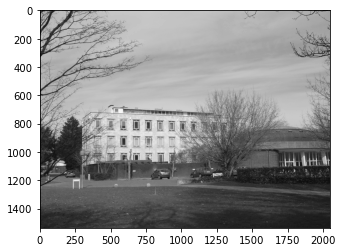

In [23]:
x = torchvision.transforms.ToTensor()(image)
print("Tensor shape:", x.shape, "min:", x.min().item(), "max:", x.max().item())
plt.imshow(x.permute(1, 2, 0), cmap='gray', vmin=0, vmax=1);

In order to be process by a layer, the tensor needs  another dimension/axis for enumerating the elements in a batch:

In [24]:
x.unsqueeze_(0)  # Add a dimension
print("Shape after adding batch dimension:", x.shape);

Shape after adding batch dimension: torch.Size([1, 1, 1536, 2048])


Now we apply a simple horizontal gradient filter:

In [25]:
hf = torch.tensor([[[[-1., 1.]]]])  # Define filter
print("Kernel:", hf, "shape:", hf.shape)

conv = nn.Conv2d(1, 1, kernel_size=(1, 2), padding=(0, 1), bias=False)  # Padding only in one dimension needed
conv.weight = torch.nn.Parameter(hf, requires_grad=False)  # Set kernel parameters to predefined filter parameters  
c = conv(x)  # Apply filter
print("Tensor shape:", c.shape, "min:", c.min().item(), "max:", c.max().item())

Kernel: tensor([[[[-1.,  1.]]]]) shape: torch.Size([1, 1, 1, 2])
Tensor shape: torch.Size([1, 1, 1536, 2049]) min: -0.9215686321258545 max: 0.8549019694328308


We do not need a gradient for the kernel parameters, so we can use ``requires_grad=False``. This allows us to use ``c[0.0]`` as a NumPy array in the visualizaiton below. Alternatively, we could use ``c[0,0].detach()`` in the ``imshow`` call.

torch.Size([1534, 2048])


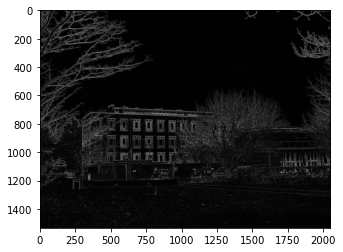

In [33]:
print(c[0,0].shape)
plt.imshow(c[0,0], cmap='gray')#, vmin=-1, vmax=1);

# Homemade Sobel Filter

In [44]:
Gx = torch.tensor([[[[1.,0.,-1.],[2.,0.,-2.],[1.,0.,-1.]]]])  # Define filter
Gy = torch.tensor([[[[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]]]])  # Define filter

print("Gx Kernel:", Gx, "shape:", Gx.shape)
print("Gy Kernel:", Gy, "shape:", Gy.shape)

Gx Kernel: tensor([[[[ 1.,  0., -1.],
          [ 2.,  0., -2.],
          [ 1.,  0., -1.]]]]) shape: torch.Size([1, 1, 3, 3])
Gy Kernel: tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]]) shape: torch.Size([1, 1, 3, 3])


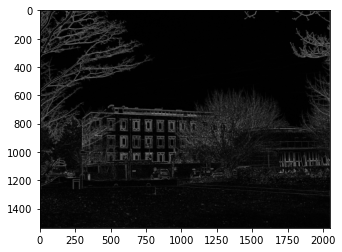

In [45]:
convX = nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1), bias=False)  # Padding only in one dimension needed
convX.weight = torch.nn.Parameter(Gx, requires_grad=False)  # Set kernel parameters to predefined filter parameters  
cX = convX(x)  # Apply filter

convY = nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1), bias=False)  # Padding only in one dimension needed
convY.weight = torch.nn.Parameter(Gy, requires_grad=False)  # Set kernel parameters to predefined filter parameters  
cY = convY(x)  # Apply filter


sq = lambda x: x*x
c = torch.sqrt(sq(cX)+sq(cY))

plt.imshow(c[0,0], cmap='gray')#, vmin=-1, vmax=1);